In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import chain

In [4]:
f_name = '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n50/n_shots2/examples_n100/seed0/intervention_1_arabic_indirect_attention_layer_output_all_tokens.feather'
data = pd.read_feather(f_name)
words = "words" in f_name

In [5]:
data.columns

Index(['example', 'template_id', 'n_vars', 'base_string', 'alt_string',
       'few_shots', 'equation', 'res_base', 'res_alt', 'res_base_base_prob',
       'res_alt_base_prob', 'res_base_alt_prob', 'res_alt_alt_prob',
       'distrib_base', 'distrib_alt', 'pred_base', 'pred_alt', 'accuracy',
       'operands_base', 'operands_alt', 'op1_pos', 'op2_pos', 'op3_pos',
       'operation', 'position', 'layer', 'neuron', 'res_base_prob',
       'res_alt_prob'],
      dtype='object')

In [6]:
data['IE'] = 0.5 * ((data['res_base_prob'] - data['res_base_alt_prob']) / data['res_base_alt_prob'] + 
                    (data['res_alt_alt_prob'] - data['res_alt_prob']) / data['res_alt_prob'])

data['IE_logits'] = 0.5 * ((data['res_base_logit'] - data['res_base_alt_logit']) / data['res_base_alt_logit'] +
                            (data['res_alt_alt_logit'] - data['res_alt_logit']) / data['res_alt_logit'])

data['patching_effect'] = (data['res_base_logit'] - data['res_alt_logit']) - (data['res_base_alt_logit'] - data['res_alt_alt_logit'])
#data['patching_effect_normalized'] = data['patching_effect'] / (data['res_base_base_logit'] - data['res_alt_base_logit'])
data['patching_effect_normalized'] = ((data['res_base_logit'] - data['res_alt_logit']) - (data['res_base_alt_logit'] - data['res_alt_alt_logit'])) / (data['res_base_base_logit'] - data['res_alt_base_logit'])
data['patching_effect_prob'] = (data['res_base_prob'] - data['res_alt_prob']) - (data['res_base_alt_prob'] - data['res_alt_alt_prob'])
data['patching_effect_prob_normalized'] = ((data['res_base_prob'] - data['res_alt_prob']) - (data['res_base_alt_prob'] - data['res_alt_alt_prob'])) / (data['res_base_base_prob'] - data['res_alt_base_prob'])


KeyError: 'res_base_logit'

In [7]:
data

,example,template_id,n_vars,base_string,alt_string,few_shots,equation,res_base,res_alt,res_base_base_prob,...,op1_pos,op2_pos,op3_pos,operation,position,layer,neuron,res_base_prob,res_alt_prob,IE
0,0,-,2,Calculate 4*5*2=,Calculate 4*5*2=,Let 2*3*2=12. Let 10*2*2=40.,({x}*{y}*{z}),40,20,0.523834,...,19,21,23,**,19,0,0,0.011489,0.739095,-0.092108
1,0,-,2,Calculate 4*5*2=,Calculate 4*5*2=,None,({x}*{y}*{z}),40,20,0.523834,...,19,21,23,**,19,1,0,0.019308,0.753375,0.176769
2,0,-,2,Calculate 4*5*2=,Calculate 4*5*2=,None,({x}*{y}*{z}),40,20,0.523834,...,19,21,23,**,19,2,0,0.017951,0.751477,0.129725
3,0,-,2,Calculate 4*5*2=,Calculate 4*5*2=,None,({x}*{y}*{z}),40,20,0.523834,...,19,21,23,**,19,3,0,0.017063,0.778408,0.081141
4,0,-,2,Calculate 4*5*2=,Calculate 4*5*2=,None,({x}*{y}*{z}),40,20,0.523834,...,19,21,23,**,19,4,0,0.014391,0.726698,0.019735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13603,62,-,2,Calculate 3+2+7=,Calculate 3+2+7=,None,({x}+{y}+{z}),12,10,0.668835,...,19,21,23,++,24,31,0,0.034977,0.148414,0.031974
13604,62,-,2,Calculate 3+2+7=,Calculate 3+2+7=,None,({x}+{y}+{z}),12,10,0.668835,...,19,21,23,++,24,32,0,0.034558,0.148944,0.024044
13605,62,-,2,Calculate 3+2+7=,Calculate 3+2+7=,None,({x}+{y}+{z}),12,10,0.668835,...,19,21,23,++,24,33,0,0.036978,0.163153,0.013265
13606,62,-,2,Calculate 3+2+7=,Calculate 3+2+7=,None,({x}+{y}+{z}),12,10,0.668835,...,19,21,23,++,24,34,0,0.058092,0.207571,0.215613


In [6]:
first_few_shots = data.groupby(['operation'])['few_shots'].first()
first_few_shots = first_few_shots.reset_index()
first_few_shots['few_shot_string'] = first_few_shots['few_shots'].apply(lambda x: x.split())
def split_on_special_characters(lst):
    # Define the regular expression pattern
    pattern = r'(\w+)([!,:?])'
    # Initialize an empty list to store the results
    result = []
    for item in lst:
        # Find all matches in the string
        matches = re.findall(pattern, item)
        if matches:
            # If matches are found, extend the result list with the split elements
            for match in matches:
                result.extend(match)
        else:
            # If no matches, just append the item as it is
            result.append(item)
    return result
# Apply the function to the 'few_shot_string' column
first_few_shots['few_shot_string'] = first_few_shots['few_shot_string'].apply(split_on_special_characters)
unique_examples_by_operation = data.groupby('operation')['example'].nunique()
first_few_shots['n_instances'] = first_few_shots['operation'].map(unique_examples_by_operation)

if 'reversed_fewshot' in f_name:
    operation_position_operands = {' *  * ': [2,4,6],
                                      ' --': [5,7,9],
                                      '* * ': [5,7,9],
                                      '**': [2, 4,6],
                                      '+ + ': [5,7,9],
                                      '++': [2, 4, 6],
                                      '-*': [6,8,11]}
else:
    operation_position_operands = {' *  * ': [3, 5, 7],
                               ' --': [3, 5, 7],
                               '* * ': [3, 5, 7],
                               '**': [0, 2, 4],
                               '+ + ': [3, 5, 7],
                               '++': [0, 2, 4],
                               '-*': [4, 6, 9]}
if 'reversed_fewshot' in f_name:
    operation_position_result = {' *  * ': 0,
                                ' --': 0,
                                '* * ': 0,
                                '**': 0,
                                '+ + ': 0,
                                '++': 0,
                                '-*': 0}
else:
    operation_position_result = {' *  * ': 9,
                                    ' --': 9,
                                    '* * ': 9,
                                    '**': 6,
                                    '+ + ': 9,
                                    '++': 6,
                                    '-*': 11}

data['position_operands'] = data['operation'].map(operation_position_operands)
data['position_result'] = data['operation'].map(operation_position_result)
data['position_first_operand'] = data['position_operands'].apply(lambda x: x[0])
data['position_second_operand'] = data['position_operands'].apply(lambda x: x[1])
data['position_third_operand'] = data['position_operands'].apply(lambda x: x[2])
data['position_first_operator'] = data['position_first_operand'] + 1
data['position_second_operator'] = data['position_third_operand'] - 1
data['position_equality_sign'] = data['position_result'] - 1
print(unique_examples_by_operation)




operation
 *  *     3
* *       2
**        2
+ +       1
++        3
Name: example, dtype: int64


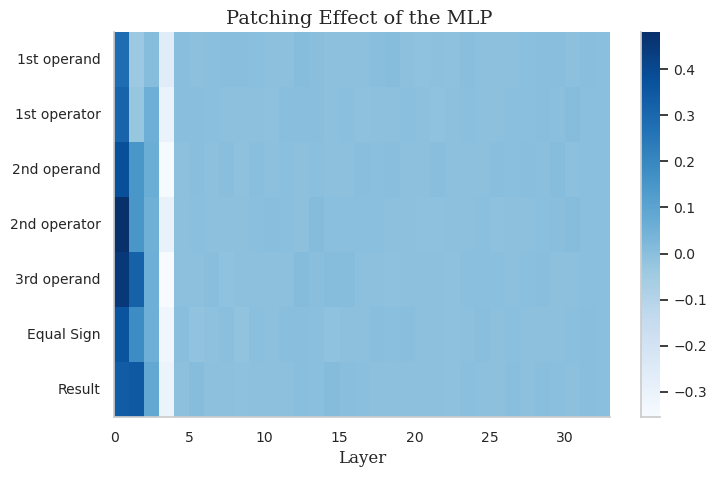

In [7]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
is_attention = "attention_layer_output" in f_name
is_mixed = "mixed" in f_name
intervention_loc = "MLP"
if is_attention:
    intervention_loc = "Attention"
    vmax = None
else:
    if is_mixed:
        intervention_loc = "embedding layer's MLP and Attention"
        vmax = None
    elif 'reversed_fewshot' in f_name:
        vmax = None
    else:
        if f_name == '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_further_templates.feather':
            vmax = None
        elif f_name == '/home/aoq559/dev/transformer/lm-arithmetic/out/EleutherAI/pythia-12b-deduped-v0/n_operands3/template_typeall/max_n20/n_shots1/examples_n30/seed0/intervention_1_arabic_indirect_layer_all_tokens_position_fewshot_counterfactual_inconsistent_symbol_operands_further_templates.feather':
            vmax = None
        else:
            vmax = None #2.6
        intervention_loc = "the MLP"
# 7 x layer matrix
matrix = np.empty((7, len(data['layer'].unique())))
for i, op in enumerate(['position_first_operand', 'position_first_operator', 'position_second_operand', 'position_second_operator', 'position_third_operand', 'position_equality_sign', 'position_result']):
    for j, layer in enumerate(data['layer'].unique()):
        subset_df = data[data[op] == data['position']]
        subset_df = subset_df[subset_df['layer'] == layer]
        matrix[i, j] = subset_df['patching_effect'].mean()
# Create a dataframe from the matrix
df = pd.DataFrame(matrix, index=['1st operand', '1st operator', '2nd operand', '2nd operator', '3rd operand', 'Equal Sign', 'Result'], columns=data['layer'].unique())

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.1)
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.heatmap(df, cmap="Blues", annot=False, fmt=".2f", cbar=True)
# set x-axis ticks to the range of unique layers
ax.set_xticks(range(data.layer.max()))

# set x-axis labels to the range of unique layers
ax.set_xticklabels(range(data.layer.max()), fontsize=10, rotation=0)
plt.xlabel('Layer', fontsize=12, fontname='DeJavu Serif')

for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

# Y-axis adjustments: Make labels horizontal and remove the y-axis title
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)
plt.ylabel('')  # Remove y-axis title

# Title and other adjustments
plt.title(f'Patching Effect of {intervention_loc} ', fontsize=14, fontname='DeJavu Serif')

# Adjust color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
#cbar.set_label(label='', size=12, weight='bold', fontname='DeJavu Serif')

# Remove chart junk
sns.despine()

#plt.savefig("patching_effect_mlp.png", format='png', bbox_inches='tight')
plt.show()




  operation                      few_shots  \
0        ++  nine + two + two = thirteen.    

                        few_shot_string  n_instances  
0  [nine, +, two, +, two, =, thirteen.]            2  


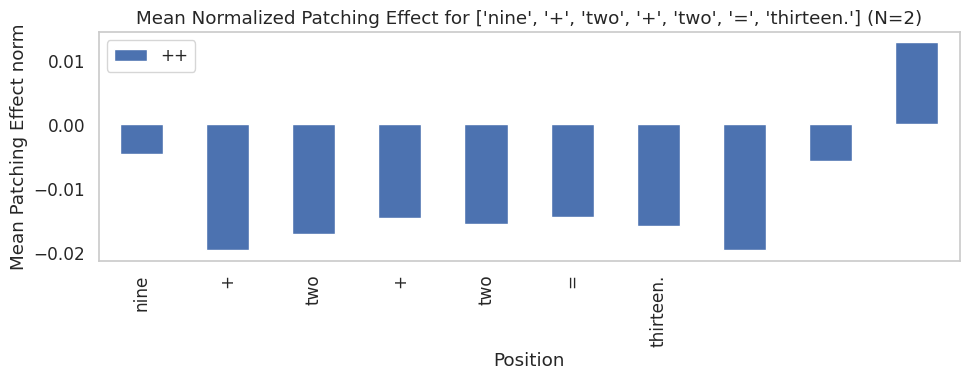

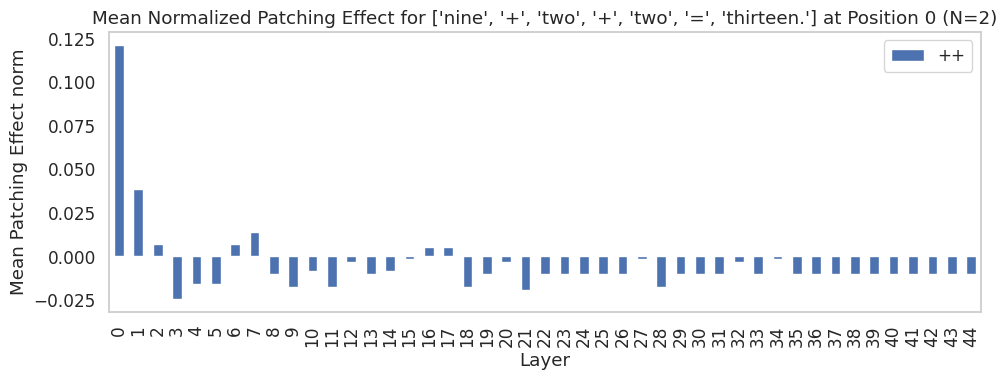

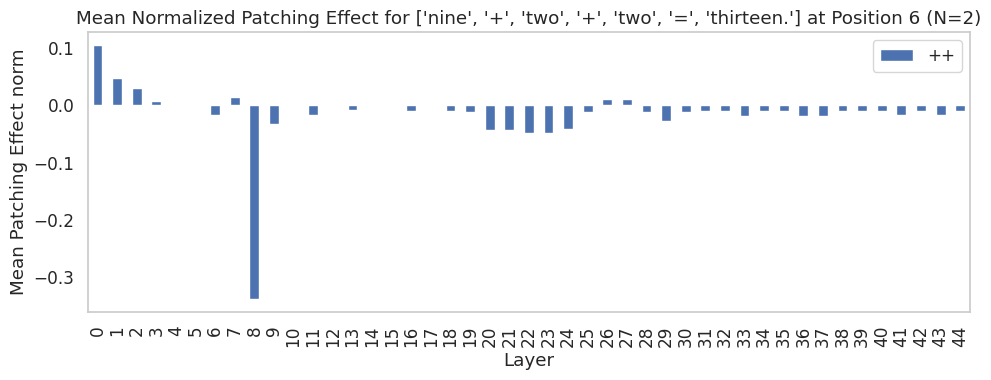

In [11]:
if words or not words:
    import re
    from itertools import chain
    
    first_few_shots = data.groupby('operation')['few_shots'].first()
    first_few_shots = first_few_shots.reset_index()
    first_few_shots['few_shot_string'] = first_few_shots['few_shots'].apply(lambda x: x.split())
    def split_on_special_characters(lst):
        # Define the regular expression pattern
        pattern = r'(\w+)([!,:?])'
        # Initialize an empty list to store the results
        result = []
        for item in lst:
            # Find all matches in the string
            matches = re.findall(pattern, item)
            if matches:
                # If matches are found, extend the result list with the split elements
                for match in matches:
                    result.extend(match)
            else:
                # If no matches, just append the item as it is
                result.append(item)
        return result
    
    # Apply the function to the 'few_shot_string' column
    first_few_shots['few_shot_string'] = first_few_shots['few_shot_string'].apply(split_on_special_characters)
    unique_examples_by_operation = data.groupby('operation')['example'].nunique()
    first_few_shots['n_instances'] = first_few_shots['operation'].map(unique_examples_by_operation)
    print(first_few_shots)
    # Group the data by operation
    grouped_data = data.groupby('operation')
    
    # Iterate over each group and create separate bar plots
    # for operation, group in grouped_data:
    #     # Filter the first_few_shots dataframe for the current operation
    #     few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
        
    #     # Calculate the mean IE for every position and operation
    #     mean_IE_by_position_operation = group.groupby('position')['IE'].mean()
        
    #     # Create a bar plot for the current operation
    #     mean_IE_by_position_operation.plot(kind='bar', xlabel='Few Shot String', ylabel='Mean IE', title=f'Mean IE by Position for {operation}')
        
    #     # Set the x-ticks to the few_shot_string values
    #     plt.xticks(range(len(few_shot_string)), few_shot_string)
        
    #     # Show the plot
    #     plt.show()

    # for operation, group in grouped_data:
    #     few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
    #     mean_IE_logits_by_position_operation = group.groupby('position')['IE_logits'].mean()
    #     mean_IE_logits_by_position_operation.plot(kind='bar', xlabel='Few Shot String', ylabel='Mean IE', title=f'Mean IE LOGITS by Position for {operation}')
    #     plt.xticks(range(len(few_shot_string)), few_shot_string)
    #     plt.show()

    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(10, 4 * len(grouped_data)))

    for i, (operation, group) in enumerate(grouped_data):
        few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
        mean_IE_by_position_operation = group.groupby('position')['patching_effect_normalized'].mean()
        ax = axes[i] if len(grouped_data) > 1 else axes
        mean_IE_by_position_operation.plot(kind='bar', xlabel='Position', ylabel='Mean Patching Effect norm', ax=ax)
        ax.set_title(f'Mean Normalized Patching Effect for {few_shot_string} (N={first_few_shots[first_few_shots["operation"] == operation]["n_instances"].values[0]})')
        ax.set_xticks(ticks=range(len(few_shot_string)), labels=few_shot_string)
        ax.legend([operation])

    plt.tight_layout()
    plt.show()

    # for operation, group in grouped_data:
    #     few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shots'].values[0]
    #     mean_IE_logits_by_layer_operation = group.groupby('layer')['IE_logits'].mean()
    #     mean_IE_logits_by_layer_operation.plot(kind='bar', xlabel='Layer', ylabel='Mean IE', title=f'Mean IE LOGITS by Layer for {few_shot_string}')
    #     plt.show()

    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(10, 4 * len(grouped_data)))
    for i,  (operation, group) in enumerate(grouped_data):
        few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
        # inspect the position with the highest mean IE except for the last position
        mean_IE_by_position_operation = group.groupby('position')['patching_effect_normalized'].mean()
        last_position = mean_IE_by_position_operation.index[-1]
        # remove the last position from mean_IE_by_position_operation
        mean_IE_by_position_operation = mean_IE_by_position_operation.drop(last_position)
        # get the positon with the highest mean IE
        highest_mean_IE_position = mean_IE_by_position_operation.idxmax()
        mean_IE_highest_position_operation = group[group['position'] == highest_mean_IE_position].groupby('layer')['patching_effect_normalized'].mean()
        #mean_IE_highest_position_operation.plot(x='layer', y='IE', kind='bar', xlabel='Layer', ylabel='Mean IE', title=f'Mean IE logits for {few_shot_string} at pos {highest_mean_IE_position}')
        ax = axes[i] if len(grouped_data) > 1 else axes
        mean_IE_highest_position_operation.plot(kind='bar', xlabel='Layer', ylabel='Mean Patching Effect norm', ax=ax)
        ax.set_title(f'Mean Normalized Patching Effect for {few_shot_string} at Position {highest_mean_IE_position} (N={first_few_shots[first_few_shots["operation"] == operation]["n_instances"].values[0]})')
        # set the xticks to the range of unique layers
        ax.set_xticks(ticks=range(len(group['layer'].unique())))
        ax.legend([operation])

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(grouped_data), 1, figsize=(10, 4 * len(grouped_data)))
    for i,  (operation, group) in enumerate(grouped_data):
        few_shot_string = first_few_shots[first_few_shots['operation'] == operation]['few_shot_string'].values[0]
        # inspect the result position mean IE
        mean_IE_by_position_operation = group.groupby('position')['patching_effect_normalized'].mean()
        last_position = len(few_shot_string) - 1
        # group the data by the last position
        mean_IE_by_position_operation = group[group['position'] == last_position].groupby('layer')['patching_effect_normalized'].mean()
        ax = axes[i] if len(grouped_data) > 1 else axes
        mean_IE_by_position_operation.plot(kind='bar', xlabel='Layer', ylabel='Mean Patching Effect norm', ax=ax)
        ax.set_title(f'Mean Normalized Patching Effect for {few_shot_string} at Position {last_position} (N={first_few_shots[first_few_shots["operation"] == operation]["n_instances"].values[0]})')
        # set the xticks to the range of unique layers
        ax.set_xticks(ticks=range(len(group['layer'].unique())))
        ax.legend([operation])

    plt.tight_layout()
    plt.show()

In [27]:
unique_examples_by_operation = data.groupby('operation')['example'].nunique()
first_few_shots['n_instances'] = first_few_shots['operation'].map(unique_examples_by_operation)
print(first_few_shots)



  operation                                 few_shots  \
0     *  *      The result of 2 times 2 times 2 = 8.    
1        --  The result of 18 minus 5 minus 2 is 11.    
2      * *             The result of 2 * 3 * 2 = 12.    
3        **                          2 * 4 * 2 = 16.    
4      + +             The result of 9 + 4 + 6 = 19.    
5        ++                         10 + 2 + 3 = 15.    
6        -*       The result of ( 15 - 14 ) * 9 = 9.    

                                     few_shot_string  n_instances  
0    [The, result, of, 2, times, 2, times, 2, =, 8.]           23  
1  [The, result, of, 18, minus, 5, minus, 2, is, ...            5  
2           [The, result, of, 2, *, 3, *, 2, =, 12.]           26  
3                            [2, *, 4, *, 2, =, 16.]            7  
4           [The, result, of, 9, +, 4, +, 6, =, 19.]           25  
5                           [10, +, 2, +, 3, =, 15.]            9  
6    [The, result, of, (, 15, -, 14, ), *, 9, =, 9.]           13  

In [15]:
unique_res_base_by_example = data.groupby('example')['res_base'].unique()
print(unique_res_base_by_example)
unique_pred_base_by_example = data.groupby('example')['pred_base'].unique()
print(unique_pred_base_by_example)
print(unique_res_base_by_example.values[1] == unique_pred_base_by_example.values[1])
print(type(unique_res_base_by_example.values[1][0]))
print(type(unique_pred_base_by_example.values[1][0]))


example
0      [nineteen]
1      [eighteen]
2        [twelve]
3      [nineteen]
4       [sixteen]
5        [eleven]
6       [fifteen]
7      [eighteen]
8       [fifteen]
9      [nineteen]
10     [eighteen]
11    [seventeen]
12         [nine]
13     [eighteen]
14       [twelve]
15      [fifteen]
16     [fourteen]
17        [eight]
18          [one]
19        [three]
20         [five]
21        [three]
22       [twelve]
23       [twelve]
24     [eighteen]
25       [twelve]
26      [sixteen]
27       [twelve]
28      [sixteen]
29      [sixteen]
30     [eighteen]
31      [sixteen]
32       [twelve]
33      [sixteen]
34     [eighteen]
35        [eight]
36       [twelve]
37       [twelve]
38      [sixteen]
39        [eight]
40        [eight]
41      [sixteen]
42       [twelve]
43        [eight]
44       [twelve]
45        [eight]
46       [twelve]
47        [eight]
48        [eight]
49       [twelve]
50       [twelve]
51          [two]
52      [sixteen]
53          [six]
54    [seventeen]
55

In [8]:
# print all unique values for column data.layer
data.layer.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

position
19    0.044814
20    0.029215
21    0.002444
22   -0.015632
23   -0.004496
24    0.229002
Name: IE, dtype: float64


<Axes: xlabel='position'>

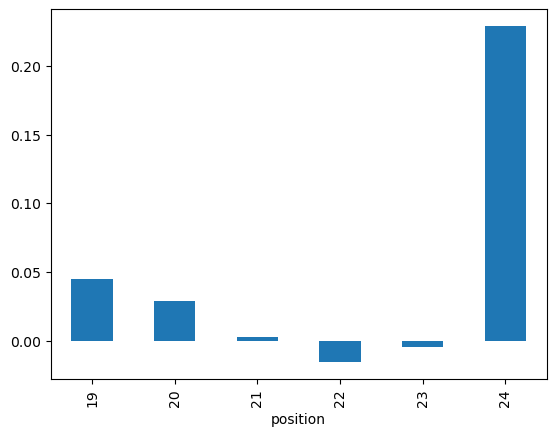

In [15]:
mean_IE_by_position_example0 = data[data['example'] == 41].groupby('position')['IE'].mean()
print(mean_IE_by_position_example0)
mean_IE_by_position_example0.plot(kind='bar')


position
19    0.018549
20    0.019325
21    0.006378
22    0.008640
23    0.018455
24    0.188133
Name: IE, dtype: float64


<Axes: xlabel='position', ylabel='Indirect Effect'>

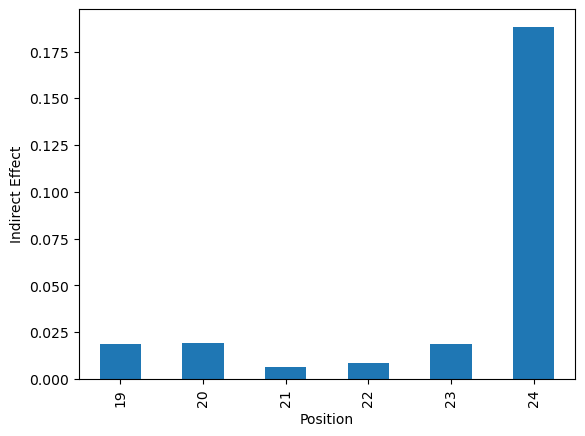

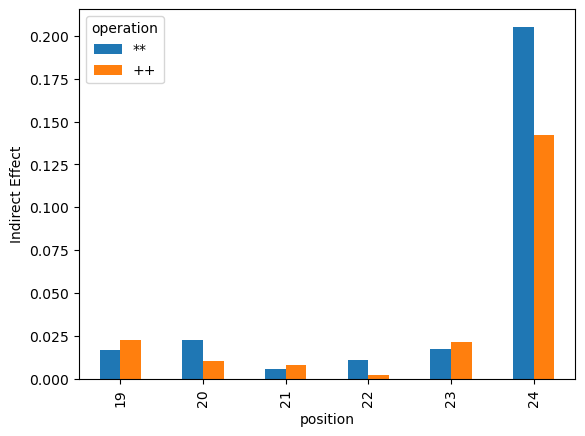

In [16]:
mean_IE_by_position = data.groupby(['position'])['IE'].mean()
print(mean_IE_by_position)
mean_IE_by_position.plot(x='position', y='Indirect Effect', kind='bar', xlabel='Position', ylabel='Indirect Effect')
mean_IE_by_position_operation = data.groupby(['position', 'operation'])['IE'].mean()
mean_IE_by_position_operation.unstack().plot(kind='bar', ylabel="Indirect Effect")



24


<Axes: xlabel='layer'>

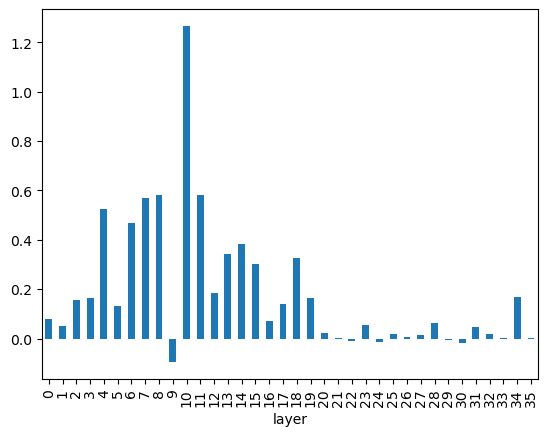

In [17]:
# inspect the position with the highest mean IE
highest_mean_IE_position = mean_IE_by_position.idxmax()
print(highest_mean_IE_position)
mean_IE_highest_position = data[data['position'] == highest_mean_IE_position].groupby('layer')['IE'].mean()
mean_IE_highest_position.plot(x='layer', y='IE', kind='bar')


<Axes: xlabel='layer', ylabel='Indirect Effect'>

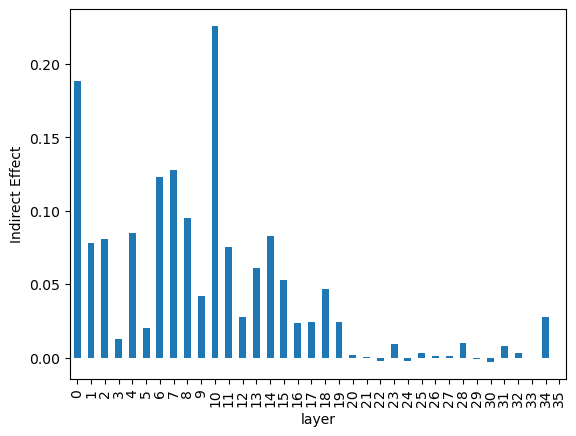

In [19]:
mean_IE_by_layer = data.groupby(['layer'])['IE'].mean()
mean_IE_by_layer.plot(x='layer', y='IE', kind='bar', ylabel='Indirect Effect')

layer
0     0.080508
1     0.052105
2     0.154508
3     0.164532
4     0.524214
5     0.131784
6     0.468731
7     0.571047
8     0.580320
9    -0.095603
10    1.265797
11    0.582631
12    0.182936
13    0.344152
14    0.383678
15    0.300651
16    0.072291
17    0.138516
18    0.327846
19    0.165528
20    0.023886
21    0.002987
22   -0.008432
23    0.055958
24   -0.013350
25    0.018429
26    0.007265
27    0.013042
28    0.064474
29   -0.005969
30   -0.017895
31    0.045619
32    0.020333
33    0.002401
34    0.166949
35    0.000934
Name: IE, dtype: float64


<Axes: xlabel='layer'>

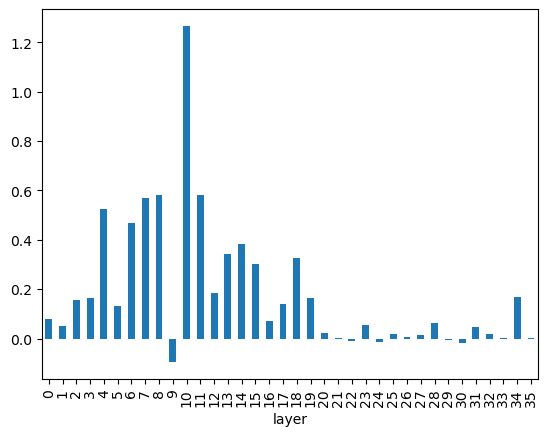

In [18]:
mean_IE_last_position_by_layer = data[data['position'] == data['position'].max()].groupby('layer')['IE'].mean()
print(mean_IE_last_position_by_layer)
mean_IE_last_position_by_layer.plot(x='layer', y='IE', kind='bar')


layer  position
0      19          0.001652
       20          0.532015
       21         -0.024959
       22          0.543253
       23         -0.002697
                     ...   
35     20          0.000000
       21          0.000000
       22          0.000000
       23          0.000000
       24          0.000934
Name: IE, Length: 216, dtype: float64


<Axes: xlabel='layer,position'>

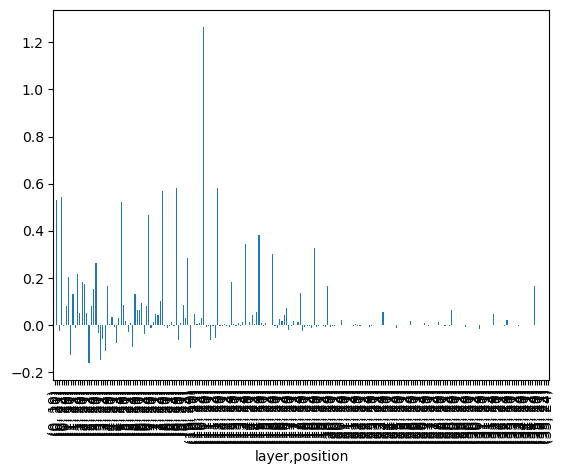

In [20]:
mean_IE_by_layer_position = data.groupby(['layer', 'position'])['IE'].mean()
print(mean_IE_by_layer_position)
mean_IE_by_layer_position.plot(x='layer', y='IE', kind='bar')



In [8]:
mean_IE_by_layer_position

layer  position
0      19          0.001652
       20          0.532015
       21         -0.024959
       22          0.543253
       23         -0.002697
                     ...   
35     20          0.000000
       21          0.000000
       22          0.000000
       23          0.000000
       24          0.000934
Name: IE, Length: 216, dtype: float64